In [3]:
#Install all required libraries and functions
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm.autonotebook import tqdm
import numpy as np #
import pandas as pd 
import keras
from keras import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from keras.preprocessing.image import load_img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [4]:
# Mount Google Drive which contains the dataset
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")
tf.config.list_physical_devices("GPU")

GPU available (YESS!!!!)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# Read labels.csv
labels = pd.read_csv('/content/drive/MyDrive/Workshop 2 Thanu/labels.csv')

In [7]:
# Create list of alphabetically sorted labels.
classes = sorted(list(set(labels['breed'])))
n_classes = len(classes)
print('Total unique breed {}'.format(n_classes))

class_to_num = dict(zip(classes, range(n_classes)))
class_to_num

Total unique breed 120


{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [8]:
import os
if len(os.listdir('/content/drive/MyDrive/Workshop 2 Thanu/train output')) == len(labels['id']):
    print('Number of file matches number of actual images!')
else:
    print('Number of file doesnot matches number of actual images!!')

Number of file matches number of actual images!


In [9]:
# Preprocess training dataset
input_shape = (331,331,3)

def images_to_array(directory, label_dataframe, target_size = input_shape):
    
    image_labels = label_dataframe['breed']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8) #as we have huge data and limited ram memory. uint8 takes less memory
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
    
    for ix, image_name in enumerate(tqdm(label_dataframe['id'].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
        
        dog_breed = image_labels[ix]
        y[ix] = class_to_num[dog_breed]
    
    y = to_categorical(y)
    
    return images,y

In [10]:
import time 
t = time.time()

X,y = images_to_array('/content/drive/MyDrive/Workshop 2 Thanu/train output', labels[:])

print('runtime in seconds: {}'.format(time.time() - t))

  0%|          | 0/10222 [00:00<?, ?it/s]

runtime in seconds: 128.31335830688477


In [11]:
n=25

def barw(ax): 
    
    for p in ax.patches:
        val = p.get_width() #height of the bar
        x = p.get_x()+ p.get_width() # x- position 
        y = p.get_y() + p.get_height()/2 #y-position
        ax.annotate(round(val,2),(x,y))
        
# setup the figure 
plt.figure(figsize=(20,20))

for i in range(n):
#     print(i)
    ax = plt.subplot(5, 5, i+1)
    plt.title(classes[np.where(y[i] ==1)[0][0]])
    plt.imshow(X[i].astype('int32')) 

Output hidden; open in https://colab.research.google.com to view.

In [12]:
# Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

# Prepare call backs
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [13]:
# Hyperparameters
batch_size= 128
epochs=40
learn_rate=.01
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

In [14]:
# Function to extract features from the dataset by a given pretrained model
img_size = (331,331,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #Extract feature.
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [15]:
# Extract features using InceptionV3 
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

320/320 [==============================] - 55s 134ms/step
Feature maps shape:  (10222, 2048)


In [16]:
# Free up some ram memory
del X 
gc.collect()

42685

In [17]:
print('Final feature maps shape', inception_features.shape)

Final feature maps shape (10222, 2048)


In [18]:
# Prepare Deep Neural Network

model = Sequential()
model.add(Dropout(0.7,input_shape=(inception_features.shape[1],)))

model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model. 
history = model.fit(inception_features, y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.3,
            callbacks=[lrr,EarlyStop])

Epoch 1/40
56/56 [==============================] - 1s 8ms/step - loss: 1.3886 - accuracy: 0.6825 - val_loss: 0.3981 - val_accuracy: 0.8728 - lr: 0.0100
Epoch 2/40
56/56 [==============================] - 0s 5ms/step - loss: 0.4897 - accuracy: 0.8621 - val_loss: 0.3961 - val_accuracy: 0.8846 - lr: 0.0100
Epoch 3/40
56/56 [==============================] - 0s 5ms/step - loss: 0.4486 - accuracy: 0.8756 - val_loss: 0.4582 - val_accuracy: 0.8836 - lr: 0.0100
Epoch 4/40
56/56 [==============================] - 0s 5ms/step - loss: 0.4476 - accuracy: 0.8860 - val_loss: 0.4589 - val_accuracy: 0.8816 - lr: 0.0100
Epoch 5/40
56/56 [==============================] - 0s 5ms/step - loss: 0.4415 - accuracy: 0.8853 - val_loss: 0.4481 - val_accuracy: 0.8934 - lr: 0.0100
Epoch 6/40
56/56 [==============================] - 0s 5ms/step - loss: 0.4185 - accuracy: 0.8927 - val_loss: 0.4993 - val_accuracy: 0.8862 - lr: 0.0100
Epoch 7/40
56/56 [==============================] - 0s 5ms/step - loss: 0.3866 - a

<Figure size 432x288 with 0 Axes>

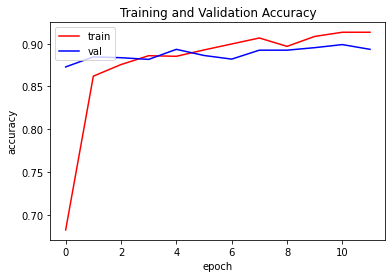

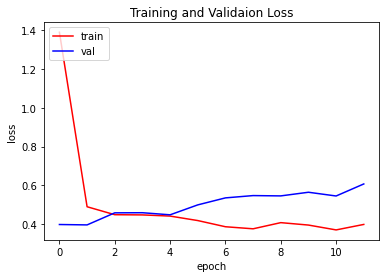

<Figure size 432x288 with 0 Axes>

In [19]:
# Plot accuracy and loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.figure()


In [20]:
# Save model
filename="models/your_model.h5"
model.save(filename)

In [21]:
# Load model
from tensorflow.keras.models import load_model
load_model(filename)

In [22]:
# Function to read images from test directory

def images_to_array_test(test_path, img_size = (299,299)):
    test_filenames = [test_path + fname for fname in os.listdir(test_path)]

    data_size = len(test_filenames)
    images = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    for ix,img_dir in enumerate(tqdm(test_filenames)):
        img = load_img(img_dir, target_size = img_size)
        images[ix]=img
        del img
    print('Ouptut Data Size: ', images.shape)
    return images

test_data = images_to_array_test('/content/drive/MyDrive/Workshop 2 Thanu/test output/', img_size)

  0%|          | 0/3915 [00:00<?, ?it/s]

Ouptut Data Size:  (3915, 331, 331, 3)


In [23]:
# Extract test data features.
def extact_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)
    print('Final feature maps shape', inception_features.shape)   
    return inception_features

test_features = extact_features(test_data)

123/123 [==============================] - 19s 146ms/step
Feature maps shape:  (3915, 2048)
Final feature maps shape (3915, 2048)


In [24]:
# Free up some space.
del test_data
gc.collect()

49520

In [25]:
# Predict test labels given test data features.
pred = model.predict(test_features)

In [26]:
# First prediction
print(pred[0])
print(f"Max value (probability of prediction): {np.max(pred[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(pred[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(pred[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {classes[np.argmax(pred[0])]}")

[2.89538193e-09 1.65720285e-10 1.36244040e-07 1.49488972e-06
 2.98990159e-07 1.82452786e-05 2.58788123e-06 1.27350944e-07
 5.17529797e-09 2.85650703e-09 6.54277299e-10 3.41973237e-06
 3.51929152e-09 7.05305592e-10 8.60217568e-08 7.87639522e-07
 9.78311479e-01 1.76728781e-06 1.03567480e-07 1.77592128e-08
 8.57626581e-10 1.83579658e-08 4.61503752e-10 1.28678238e-07
 2.55794603e-08 3.61362962e-09 1.26482931e-08 2.93817408e-07
 1.71476344e-07 1.63106306e-09 4.69725769e-09 3.06957020e-08
 9.12354281e-09 2.15866752e-02 1.57834759e-08 2.52674237e-08
 1.04387821e-09 1.78824167e-09 9.12980525e-10 2.37771780e-09
 1.69366467e-05 1.54130877e-08 3.08101278e-07 2.87099823e-07
 1.17545069e-05 6.97258432e-11 2.91139145e-07 1.21976180e-08
 4.10292742e-08 7.44227691e-06 1.62097500e-08 9.58160967e-07
 1.29530304e-06 2.13639112e-07 1.53896373e-09 5.99738526e-09
 9.13994547e-10 3.08057663e-10 1.35771297e-10 8.16227657e-06
 1.08172546e-08 9.18609011e-09 1.28906015e-08 1.24564758e-06
 1.44800216e-09 7.473709

In [27]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(classes))

In [28]:
# Append test image ID's to predictions DataFrame
test_path = "/content/drive/MyDrive/Workshop 2 Thanu/test output/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,47f7816b1e509621024f963aa2189d56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,47cfe30ba8473b81425aa3f7d11c2191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4800366e595ebc85ba05f158e0c7d757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,47f06706bdd5ef19ff945d98f921eae6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,485095f5467aad04bf2a7699a58860bd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
preds_df.loc[:,list(classes)]= pred
preds_df.to_csv('submission.csv',index=None)

In [30]:
img_g = load_img('/content/drive/MyDrive/Workshop 2 Thanu/bull dog.jpg',target_size = (331,331,3))
img_g = np.expand_dims(img_g, axis=0)

In [31]:
img_g.shape

(1, 331, 331, 3)

In [32]:
# Predict test labels given test data features.
test_features = extact_features(img_g)
predg = model.predict(test_features)
print(f"Predicted label: {classes[np.argmax(predg[0])]}")
print(f"Probability of prediction): {round(np.max(predg[0])) * 100} %")

1/1 [==============================] - 2s 2s/step
Feature maps shape:  (1, 2048)
Final feature maps shape (1, 2048)
Predicted label: bull_mastiff
Probability of prediction): 100 %
